# Topic Modelling of All NeurIPS (NIPS) Papers

Topic modeling is used to extract topics with keywords in unlabeled documents. 


## Background
The Conference and Workshop on Neural Information Processing Systems (abbreviated as NeurIPS and formerly NIPS) is a machine learning and computational neuroscience conference that holds every December.

This dataset is inspired by dataset [NIPS Papers of Ben Hamner](https://www.kaggle.com/benhamner/nips-papers). While the original dataset by Ben Hamner represent the time period of 1987-2017 covering over 7241 papers, 2439 more papers has been published in the year of 2018-19. Hence, Rohit Swami decided to get everything together for the Kaggle community [here](https://www.kaggle.com/rowhitswami/nips-papers-1987-2019-updated?select=papers.csv).

## Data
There are two datasets;

- Authors: Containing author details
- Papers: This dataset contains the source id, year of publication, title, abstracts, and full text of all NeurIPS papers from 1987 to 2019.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from collections import Counter
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk import pos_tag

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

## EDA

In [2]:
authors = pd.read_csv('NeurIPS Papers/authors.csv')
authors.head()

,source_id,first_name,last_name,institution
0,27,Alan,Murray,NaN
1,27,Anthony,Smith,NaN
2,27,Zoe,Butler,NaN
3,63,Yaser,Abu-Mostafa,NaN
4,60,Michael,Fleisher,NaN


In [3]:
authors['full_name'] = authors['first_name'] + ' ' + authors['last_name']
authors['full_name'].nunique()

14035

There are 14,035 unique authors contributing to NIPS papers

In [4]:
papers = pd.read_csv('NeurIPS Papers/papers.csv')
papers.head()

,source_id,year,title,abstract,full_text
0,27,1987,Bit-Serial Neural Networks,NaN,573 \n\nBIT - SERIAL NEURAL NETWORKS \n\nAlan...
1,63,1987,Connectivity Versus Entropy,NaN,1 \n\nCONNECTIVITY VERSUS ENTROPY \n\nYaser S...
2,60,1987,The Hopfield Model with Multi-Level Neurons,NaN,278 \n\nTHE HOPFIELD MODEL WITH MUL TI-LEVEL N...
3,59,1987,How Neural Nets Work,NaN,442 \n\nAlan Lapedes \nRobert Farber \n\nThe...
4,69,1987,Spatial Organization of Neural Networks: A Pro...,NaN,740 \n\nSPATIAL ORGANIZATION OF NEURAL NEn...


In [5]:
papers.shape

(9680, 5)

In [6]:
papers.isnull().sum()

source_id       0
year            0
title           0
abstract     3319
full_text       3
dtype: int64

The papers dataset contains some missing values in the 'abstract' and 'full_text' columns, but because I did not use these columns at all, I did not bother with the missing values

In [7]:
papers['source_id'].value_counts().head(10)

914     9
535     8
805     8
354     8
1143    8
95      8
93      8
1269    8
1100    8
780     8
Name: source_id, dtype: int64

Source ID is not unique to each publication, some publications have the same source ID, so the research were probably sponsored by the same institution.

2019    1428
2018    1009
2017     679
2016     569
2014     411
2015     403
2012     370
2013     360
2011     306
2010     292
2009     262
2008     250
2007     217
2005     207
2004     207
2002     207
2006     204
2003     198
2001     197
1993     158
1995     152
2000     152
1996     152
1998     151
1999     150
1997     150
1991     144
1990     143
1994     140
1992     127
1989     101
1988      94
1987      90
Name: year, dtype: int64

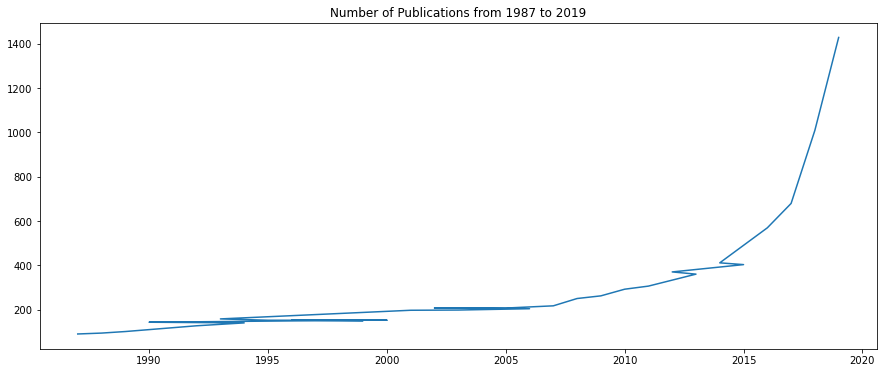

In [8]:
#a quick look into the number of NIPS publications yearly
papers['year'].value_counts().plot(figsize=(15,6), title="Number of Publications from 1987 to 2019")
papers['year'].value_counts()

Over the years, Machine Learning Engineers and Neuroscientists have continued to release more and more publications starting with 90 publications in 1987 to more than 1400 publications in 2019.

In [9]:
stopwords = list(stopwords.words("english"))

In [10]:
def freq_words(x, N = 30):
    all_words = ' '.join([text.lower() for text in x])
    all_words = all_words.split()
    for word in all_words:
        if word in stopwords:
            all_words.remove(word)
    
    words_counter = Counter(all_words)
    words_df = pd.DataFrame({'word':list(words_counter.keys()), 'count':list(words_counter.values())})
    
    # selecting top N words
    d = words_df.nlargest(columns="count", n = N) 

    plt.figure(figsize=(20,7))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set_ylabel('Count', fontsize=15)
    ax.set_xlabel('Words'.format(N), fontsize=15)
    ax.set_title("Top {} Words Used in Paper Titles".format(N), fontsize=17)
    plt.xticks(rotation=45, fontsize=12)
    plt.show()

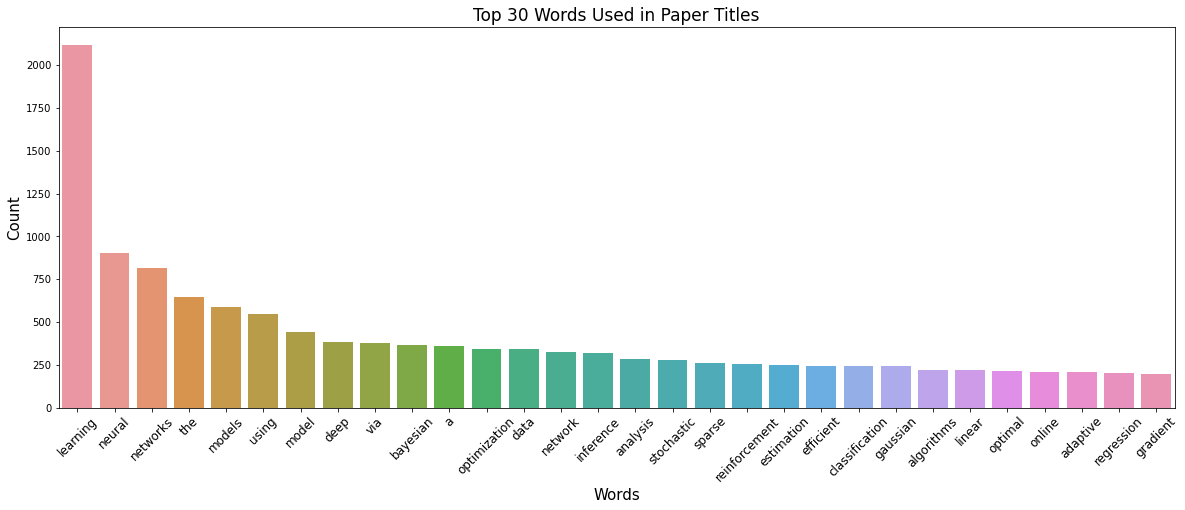

In [11]:
freq_words(papers['title'])

As expected the most common words are the popular Deep Learning jargons like learning, neural, networks, optimization, model etc

## Modelling

I used the Latent Dirichlet Allocation model from sklearn.

Latent Dirichlet Allocation(LDA) is a topic modeling algorithm based on Dirichlet distribution. The procedure of LDA can be explained as follows:
1. Choose a fixed number of topics(=k).
2. Go through each document, and randomly assign each word of the document to one of the k documents.
3. Iterate over each word in every document.
4. For each word in every document, for each topic t, find:

`P(t|d) = Proportion of words in document d that are currently assigned to topic t  
P(w|t) = Proportion of assignments to topic t over all documents that come from this word w`

5. Reassign each word w a new topic, using:
`t(w) = p(t|d) * p(w|t) = Probability that topic t generated word w`

#### Text Preprocessing

1. Clean the text by removing punctuations and stopwords
2. Extract the nouns and adjectives in each title
3. Create a vectorized document term matrix with TF-IDF Vectorization

In [12]:
#function to remove punctuations and stopwords from text
def clean_titles(text):
    """Given a text, convert to lowercase, remove all punctuations and remove stopwords"""
    clean = text.lower()  #lowercase
    clean = re.sub(r'[^\w\s]','', clean)
    tokens = word_tokenize(clean)
    for word in tokens:
        if word in stopwords:
            tokens.remove(word)
    
    return ' '.join(tokens)

In [13]:
#function to extract only nouns and adjectives from text using NLTK's pos_tag
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [14]:
#cleaned the title column and saved the clean version in a new column
papers['clean_title'] = papers['title'].apply(clean_titles)

In [15]:
papers['title_nouns_adj'] = papers['clean_title'].apply(nouns_adj)
papers.head(10)

,source_id,year,title,abstract,full_text,clean_title,title_nouns_adj
0,27,1987,Bit-Serial Neural Networks,NaN,573 \n\nBIT - SERIAL NEURAL NETWORKS \n\nAlan...,bitserial neural networks,bitserial neural networks
1,63,1987,Connectivity Versus Entropy,NaN,1 \n\nCONNECTIVITY VERSUS ENTROPY \n\nYaser S...,connectivity versus entropy,connectivity versus entropy
2,60,1987,The Hopfield Model with Multi-Level Neurons,NaN,278 \n\nTHE HOPFIELD MODEL WITH MUL TI-LEVEL N...,hopfield model multilevel neurons,hopfield model multilevel neurons
3,59,1987,How Neural Nets Work,NaN,442 \n\nAlan Lapedes \nRobert Farber \n\nThe...,neural nets work,neural nets
4,69,1987,Spatial Organization of Neural Networks: A Pro...,NaN,740 \n\nSPATIAL ORGANIZATION OF NEURAL NEn...,spatial organization neural networks probabili...,spatial organization neural networks probabili...
5,6,1987,A Neural-Network Solution to the Concentrator ...,NaN,775 \n\nA NEURAL-NETWORK SOLUTION TO THE C...,neuralnetwork solution the concentrator assign...,neuralnetwork solution concentrator assignment...
6,33,1987,LEARNING BY STATE RECURRENCE DETECTION,NaN,642 \n\nLEARNING BY ST ATE RECURRENCE DETECfIO...,learning state recurrence detection,state recurrence detection
7,36,1987,Stability Results for Neural Networks,NaN,554 \n\nSTABILITY RESULTS FOR NEURAL NETWORK...,stability results neural networks,stability results neural networks
8,35,1987,Introduction to a System for Implementing Neur...,NaN,804 \n\nINTRODUCTION TO A SYSTEM FOR IMPLEMEN...,introduction a system implementing neural net ...,introduction system neural net connections sim...
9,19,1987,Optimization with Artificial Neural Network Sy...,NaN,474 \n\nOPTIMIZA nON WITH ARTIFICIAL NEURAL NE...,optimization artificial neural network systems...,optimization artificial neural network systems...


I chose to separate the documents into 10 topics, so that the outputs will be heterogenous

In [16]:
tfidf = TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english', token_pattern=r'(?u)\b[A-Za-z]+\b')
dtm = tfidf.fit_transform(papers['title_nouns_adj'])

#### Model Training and Topic Identification

In [17]:
lda = LatentDirichletAllocation(random_state=1, learning_decay=0.5, n_components=10)

In [18]:
lda.fit(dtm)

LatentDirichletAllocation(learning_decay=0.5, random_state=1)

In [19]:
topic_results = lda.transform(dtm)

In [20]:
topic_results[0]

array([0.0414264 , 0.04142522, 0.62717692, 0.04142377, 0.04142616,
       0.0414241 , 0.04142374, 0.04142476, 0.04142358, 0.04142535])

The array above, is an array of probabilties and it shows that there is a 62% chance that the first paper, has been grouped under topic 2

**Display the results**

In [21]:
for index, topic in enumerate(lda.components_):
    print(f"THE TOP 7 WORDS FOR TOPIC #{index}")
    list_keywords = [tfidf.get_feature_names()[index] for index in topic.argsort()[-7:]]
    print(list_keywords)
    print("\n")

THE TOP 7 WORDS FOR TOPIC #0
['image', 'adaptation', 'networks', 'neural', 'language', 'natural', 'dynamics']


THE TOP 7 WORDS FOR TOPIC #1
['stochastic', 'active', 'methods', 'policy', 'learning', 'descent', 'gradient']


THE TOP 7 WORDS FOR TOPIC #2
['visual', 'network', 'convolutional', 'deep', 'recurrent', 'neural', 'networks']


THE TOP 7 WORDS FOR TOPIC #3
['dynamical', 'fields', 'systems', 'reduction', 'random', 'reinforcement', 'learning']


THE TOP 7 WORDS FOR TOPIC #4
['variational', 'neural', 'data', 'optimization', 'matrix', 'stochastic', 'bandits']


THE TOP 7 WORDS FOR TOPIC #5
['value', 'monte', 'machines', 'carlo', 'function', 'support', 'vector']


THE TOP 7 WORDS FOR TOPIC #6
['rank', 'topic', 'machine', 'detection', 'density', 'graphs', 'estimation']


THE TOP 7 WORDS FOR TOPIC #7
['hierarchical', 'sparse', 'tensor', 'clustering', 'pca', 'feature', 'kernels']


THE TOP 7 WORDS FOR TOPIC #8
['regression', 'latent', 'markov', 'process', 'gaussian', 'inference', 'model

In [22]:
# linking topic to each of the papers
papers['Topic'] = topic_results.argmax(axis=1)
papers.head(10)

,source_id,year,title,abstract,full_text,clean_title,title_nouns_adj,Topic
0,27,1987,Bit-Serial Neural Networks,NaN,573 \n\nBIT - SERIAL NEURAL NETWORKS \n\nAlan...,bitserial neural networks,bitserial neural networks,2
1,63,1987,Connectivity Versus Entropy,NaN,1 \n\nCONNECTIVITY VERSUS ENTROPY \n\nYaser S...,connectivity versus entropy,connectivity versus entropy,7
2,60,1987,The Hopfield Model with Multi-Level Neurons,NaN,278 \n\nTHE HOPFIELD MODEL WITH MUL TI-LEVEL N...,hopfield model multilevel neurons,hopfield model multilevel neurons,2
3,59,1987,How Neural Nets Work,NaN,442 \n\nAlan Lapedes \nRobert Farber \n\nThe...,neural nets work,neural nets,2
4,69,1987,Spatial Organization of Neural Networks: A Pro...,NaN,740 \n\nSPATIAL ORGANIZATION OF NEURAL NEn...,spatial organization neural networks probabili...,spatial organization neural networks probabili...,0
5,6,1987,A Neural-Network Solution to the Concentrator ...,NaN,775 \n\nA NEURAL-NETWORK SOLUTION TO THE C...,neuralnetwork solution the concentrator assign...,neuralnetwork solution concentrator assignment...,4
6,33,1987,LEARNING BY STATE RECURRENCE DETECTION,NaN,642 \n\nLEARNING BY ST ATE RECURRENCE DETECfIO...,learning state recurrence detection,state recurrence detection,4
7,36,1987,Stability Results for Neural Networks,NaN,554 \n\nSTABILITY RESULTS FOR NEURAL NETWORK...,stability results neural networks,stability results neural networks,3
8,35,1987,Introduction to a System for Implementing Neur...,NaN,804 \n\nINTRODUCTION TO A SYSTEM FOR IMPLEMEN...,introduction a system implementing neural net ...,introduction system neural net connections sim...,6
9,19,1987,Optimization with Artificial Neural Network Sy...,NaN,474 \n\nOPTIMIZA nON WITH ARTIFICIAL NEURAL NE...,optimization artificial neural network systems...,optimization artificial neural network systems...,2


In [23]:
papers['Topic'].value_counts()

8    1220
2    1079
4    1038
9     993
3     975
1     968
7     916
5     907
0     877
6     707
Name: Topic, dtype: int64

<AxesSubplot:title={'center':'Topic Distribution'}>

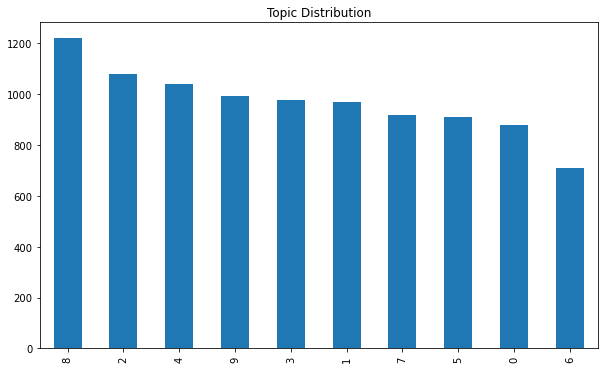

In [24]:
papers['Topic'].value_counts().plot(kind='bar', figsize=(10, 6), title='Topic Distribution')

Most of the papers fall under topic 8 and the most common keywords for this topic are **'regression', 'latent', 'markov', 'process', 'gaussian', 'inference', 'models'**